In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.coordinates import SkyCoord, Distance, BarycentricMeanEcliptic
from astropy.time import Time
from astropy import units as u
from astroquery.simbad import Simbad

# Jupyter Notebook setup for local corgietc + roman_pointing ( i was having some issues and this resolved it on my computer)
import sys
from pathlib import Path

# Base path to your local repositories
CODE_ROOT = Path(r"C:/Users/tasni/OneDrive/Documents")

# Paths to key repos
CORGIETC_PATH = CODE_ROOT / "corgietc"
CGI_NOISE_PATH = CODE_ROOT / "cgi_noise"

# Path to the folder that contains roman_pointing.py
roman_module_path = Path(r"C:/Users/tasni/OneDrive/Documents/roman_pointing/src/roman_pointing")

if str(roman_module_path) not in sys.path:
    sys.path.append(str(roman_module_path))

import roman_pointing

# Assign functions for convenience
calcRomanAngles = roman_pointing.calcRomanAngles
getL2Positions = roman_pointing.getL2Positions
getSunPositions = roman_pointing.getSunPositions

print("roman_pointing functions loaded successfully!")


roman_pointing functions loaded successfully!


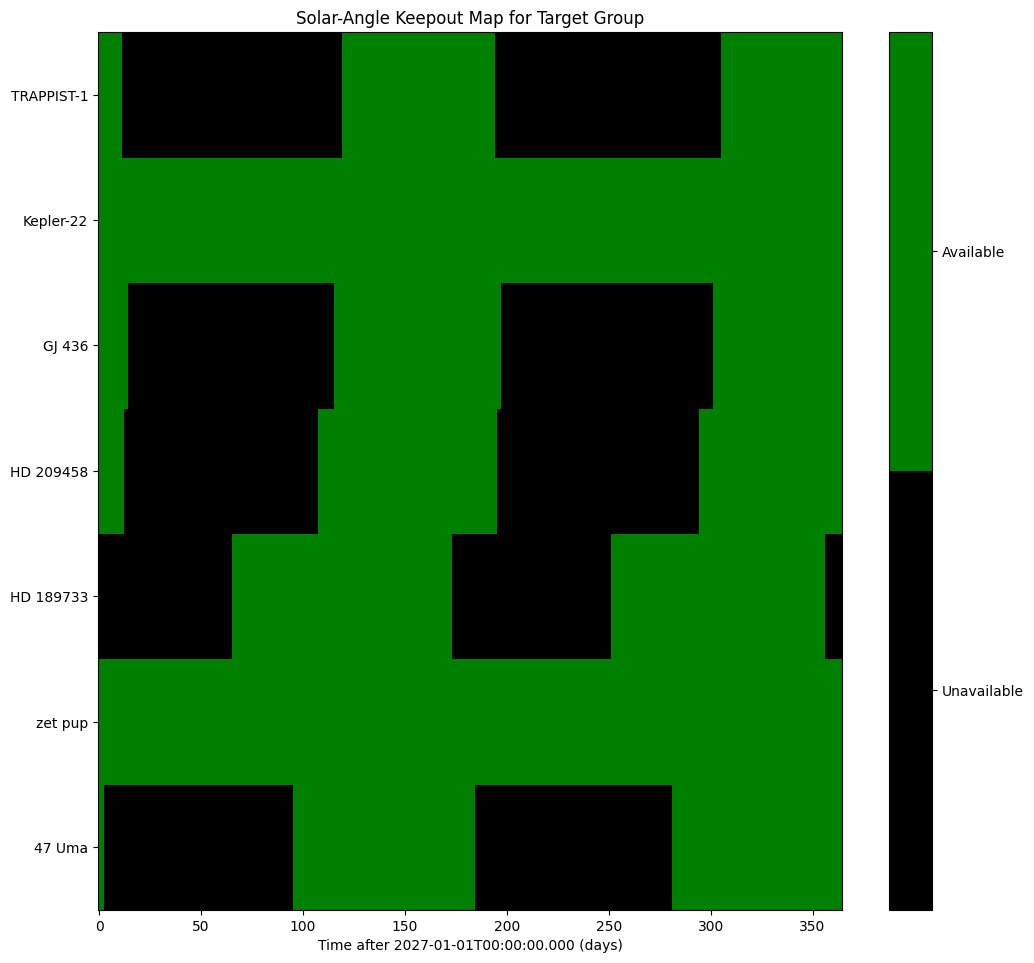

In [2]:
# 1. Query SIMBAD for a group of target stars
# 2. Convert them to BarycentricMeanEcliptic SkyCoord
# 3. Compute Roman pointing angles (sun, yaw, pitch) over one year
# 4. Build a multi-target solar keepout availability map


#   SIMBAD query, BarycentricMeanEcliptic SkyCoord
def query_targets_simbad(target_names):
    simbad = Simbad()
    simbad.add_votable_fields("pmra", "pmdec", "plx_value", "rvz_radvel")

    coords = {}
    for name in target_names:
        res = simbad.query_object(name)
        if res is None:
            print(f"WARNING: {name} not found in SIMBAD")
            continue

        c_icrs = SkyCoord(
            res["ra"].value.data[0],
            res["dec"].value.data[0],
            unit=(res["ra"].unit, res["dec"].unit),
            frame="icrs",
            distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
            pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
            pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
            radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
            equinox="J2000",
            obstime="J2000",
        )

        coords[name] = c_icrs.transform_to(BarycentricMeanEcliptic)

    return coords

#  Compute Roman pointing angles over a full year
def compute_year_pointing(coord, start_date="2027-01-01T00:00:00.0"):
    t0 = Time(start_date, format="isot", scale="utc")
    ts = t0 + np.arange(365) * u.d

    sun_ang, yaw, pitch, B_C_I = calcRomanAngles(
        coord,
        ts,
        getL2Positions(ts)
    )

    return ts, sun_ang, yaw, pitch, B_C_I


# Multi-target keepout map (reference-style)
def make_keepout_map_reference_style(solar_angle_dict, ts, min_sun=54, max_sun=126):
    names = list(solar_angle_dict.keys())
    M = len(names)
    N = len(ts)

    angs = np.vstack([solar_angle_dict[name].to_value(u.deg) for name in names])

    if angs.shape != (M, N):
        raise ValueError(f"Keepout matrix must be ({M}, {N}), got {angs.shape}")

    komap = (angs > min_sun) & (angs < max_sun)

    fig, ax = plt.subplots(1, 1, figsize=(12, 1.2*M + 3))
    cmap = matplotlib.colors.ListedColormap(["black", "green"])

    p = ax.pcolor(
        np.arange(N),
        np.arange(M),
        komap,
        cmap=cmap,
    )

    ax.set_xlabel(f"Time after {ts[0].value} (days)")
    ax.set_yticks(np.arange(M))
    ax.set_yticklabels(names)

    cbar = plt.colorbar(p, ticks=[0.25, 0.75], drawedges=True)
    cbar.ax.set_yticklabels(["Unavailable", "Available"])

    ax.set_title("Solar-Angle Keepout Map for Target Group")
    return fig, ax

if __name__ == "__main__":

    # 1. Define target list
    targets = ["47 Uma", "zet pup", "HD 189733", "HD 209458", "GJ 436", "Kepler-22","TRAPPIST-1" ]

    # 2. Query SIMBAD
    coords = query_targets_simbad(targets)

    # 3. Compute 1-year Roman angles for each target
    solar_angles = {}
    ts_global = None

    for name, coord in coords.items():
        ts, sun_ang, yaw, pitch, B_C_I = compute_year_pointing(coord)
        solar_angles[name] = sun_ang
        if ts_global is None:
            ts_global = ts

    # 4. Build keepout map
    fig, ax = make_keepout_map_reference_style(solar_angles, ts_global)
    plt.show()
